# Packages

In [1]:
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import time
from sklearn import metrics
from collections import Counter
from sklearn.feature_selection import mutual_info_classif,f_classif
from sklearn.feature_selection import VarianceThreshold, SelectKBest 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV 
import joblib
from matplotlib.colors import ListedColormap
from sklearn.metrics import make_scorer,matthews_corrcoef, average_precision_score
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Set the default text font size
plt.rcParams["font.family"] = "default"
plt.rc('font', size=12)# Set the axes title font size
plt.rc('axes', titlesize=12)# Set the axes labels font size
plt.rc('axes', labelsize=12)# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)# Set the legend font size
plt.rc('legend', fontsize=12)# Set the font size of the figure title
plt.rc('figure', titlesize=12)

# Data

In [3]:
df_preprocessed=pd.read_csv('df_after_preprocessing.csv',index_col=0)

final_variables=['BHWinstreak', 'BHLosestreak', 'BAWinstreak', 'BALosestreak', 'cHS',
       'cHF', 'cHY', 'cHR', 'r3FTHG', 'r3HC', 'r3HY', 'r3HR', 'r4HR', 'r5HR',
       'WinsOverH', 'LossesOverH', 'WinstreakH', 'LosestreakH', 'cAF', 'cAR',
       'r3AC', 'r3AF', 'r3AY', 'r3AR', 'r4AR', 'r5FTAG', 'r5AR', 'ewm03_xGA',
       'LoserateA', 'WinsOverA', 'LossesOverA', 'WinstreakA', 'LosestreakA',
       'RestH', 'RestYesNoH', 'FormationCatH', 'FormationChangeH', 'RestA',
       'RestYesNoA', 'FormationCatA', 'FormationChangeA', 'Markov_ratingH',
       'OD_ratingH', 'OD_ratingA', 'SpreadH', 'SpreadA', 'SpreadD', 'HomeAdv',
       'HomeAdv2', 'HomeAdv3', 'HAvgAge', 'HForeigner', 'AAvgAge',
       'AForeigner']
target=['FTR']

df=df_preprocessed[final_variables+target]

X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=10,window=20,forecast=8)

y_test_adh=y_test.copy()
y_train = LabelEncoder().fit_transform(y_train.values.ravel())
y_test = LabelEncoder().fit_transform(y_test.values.ravel())
print(Counter(y_train))
print(Counter(y_test))

Counter({2: 90, 0: 65, 1: 45})
Counter({2: 37, 0: 26, 1: 17})


# Penalty

In [8]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.500 (0.061)


>0.0000 0.420 (0.114)
>0.0001 0.450 (0.000)
>0.0010 0.450 (0.000)
>0.0100 0.540 (0.037)
>0.1000 0.580 (0.051)
>1.0000 0.490 (0.051)


findfont: Font family ['default'] not found. Falling back to DejaVu Sans.


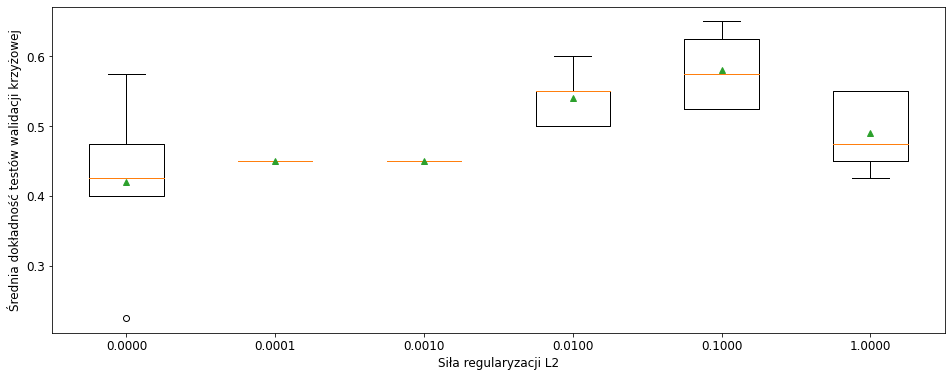

In [13]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 
# define dataset
X, y = X_train,y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
fig, axs = plt.subplots(ncols=1,figsize=(16,6))
axs.boxplot(results, labels=names, showmeans=True)
axs.set_xlabel("Siła regularyzacji L2")
axs.set_ylabel("Średnia dokładność testów walidacji krzyżowej")
fig.savefig('lr_penalties.jpg',bbox_inches='tight')
plt.show()


# Functions

In [10]:
rps_scorer= make_scorer(functions.rps, needs_proba=True)
roc_auc_ovr_scorer = make_scorer(roc_auc_score, needs_proba=True,multi_class='ovr')
auprc= make_scorer(functions.multi_auprc, needs_proba=True, greater_is_better=True)

In [11]:

def run_classifier(clf, param_grid, title,X_train,y_train):
    # -----------------------------------------------------
    
    pipe = Pipeline([
    ('selector', SelectKBest()),
    ('classifier', clf)
    ])

    # -----------------------------------------------
    
    scoring = {"Accuracy": 'accuracy',"Log_loss":'neg_log_loss',"Precision":make_scorer(precision_score, average = 'macro'),'Recall': make_scorer(recall_score, average = 'macro'),
               'Matthews_corrcoef': make_scorer(matthews_corrcoef),'F1_score':'f1_macro',"AUC":roc_auc_ovr_scorer, 'RPS': rps_scorer}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipe, param_grid, cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1).fit(X_train, y_train)

    # -----------------------------------------------------
    print("The best parameters are %s" % (grid.best_params_)) 

    #y_pred = grid.best_estimator_.predict(X_test)
    #y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------

    joblib.dump(grid, 'grid_'+title+'.pkl')

    #------------------------------------------------



def classifier_plots(grid):
    #-----------------------------------------------------------
    
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------
    # CONFUSSION MATRIX
    #------------------------------------------------------

    fig, ax = plt.subplots(1, 1, figsize = (12,6))
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax)
    #ax.set_title("Macierz błędów")
    ax.set_xlabel("Klasa predykowana")
    ax.set_ylabel("Klasa rzeczywista")
    target_names=['Gość', 'Remis', 'Gospodarz']
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)
    fig.tight_layout()
    fig.savefig("lr_conf_matrix.jpg",bbox_inches='tight')
    plt.show()  

    # -----------------------------------------------------

    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred, average= 'weighted')*100))
    print('---------------------------------')

    #------------------------------------------------------------
    # ROC CURVES AND HISTOGRAMS
    #-----------------------------------------------------------
    
    classes = grid.classes_
    classes_names=['Gość', 'Remis', 'Gospodarz']

    plt.figure(figsize = (16,9))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}

    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        cn=classes_names[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = X_test.copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(cn)
        ax.legend([f"Klasa: {cn}", "Reszta"])
        ax.set_xlabel(f"P(x = {cn})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = functions.get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        functions.plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("Krzywa ROC OvR")
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
        
    plt.tight_layout()
    plt.savefig("lr_roc_auc.jpg",bbox_inches='tight')
    plt.show()

    # Displays the ROC AUC for each class
    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    print('---------------------------------')


# Pipeline

In [1]:
# lr = LogisticRegression()

# parameters = {
#  'selector__score_func': [f_classif, mutual_info_classif],
#  'selector__k': [5,10,20,54],
#  'classifier__C':[0.0001, 0.001, 0.01, 0.1, 1.0],
#  'classifier__class_weight':['balanced',None],
#  'classifier__solver':['newton-cg','sag','saga','lbfgs'],
#  'classifier__max_iter':[100],
#  'classifier__penalty':['l2',None],
#  'classifier__multi_class':['multinomial']
# }

# run_classifier(clf=lr, param_grid=parameters, title='Logistic_Regression_20kolejek',X_train=X_train,y_train=y_train)

findfont: Font family ['default'] not found. Falling back to DejaVu Sans.


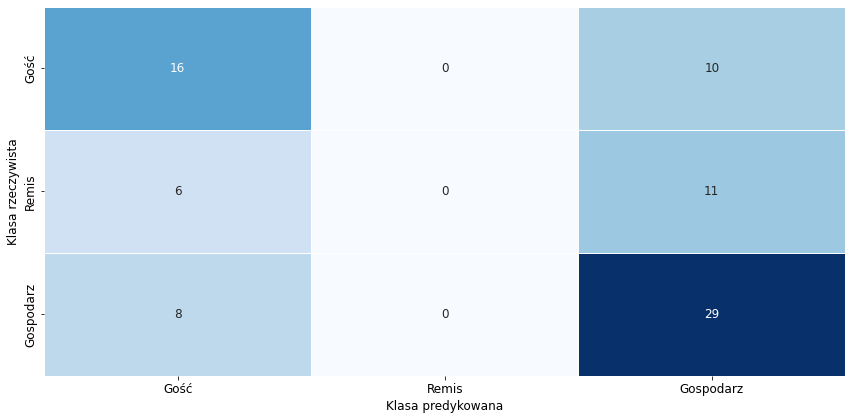

Accuracy score: 56.25%
Precision score: 44.16%
Recall score: 56.25%
---------------------------------


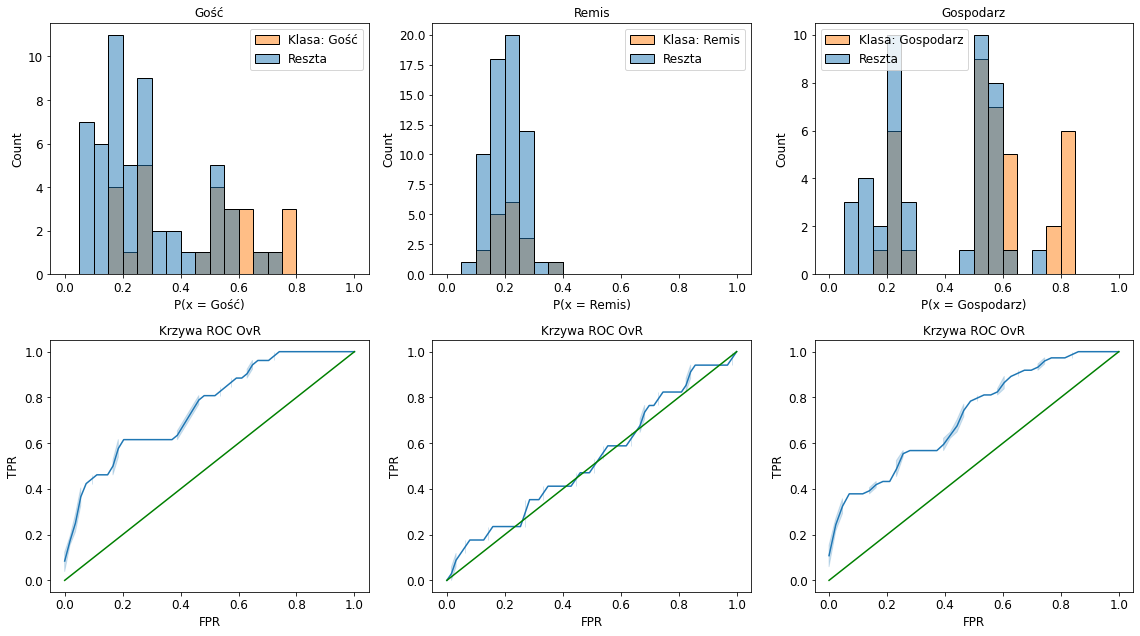

0 ROC AUC OvR: 0.7564
1 ROC AUC OvR: 0.5303
2 ROC AUC OvR: 0.7172
average ROC AUC OvR: 0.6680
---------------------------------


In [12]:
grid=joblib.load('grid_Logistic_Regression_20kolejek.pkl')

classifier_plots(grid)

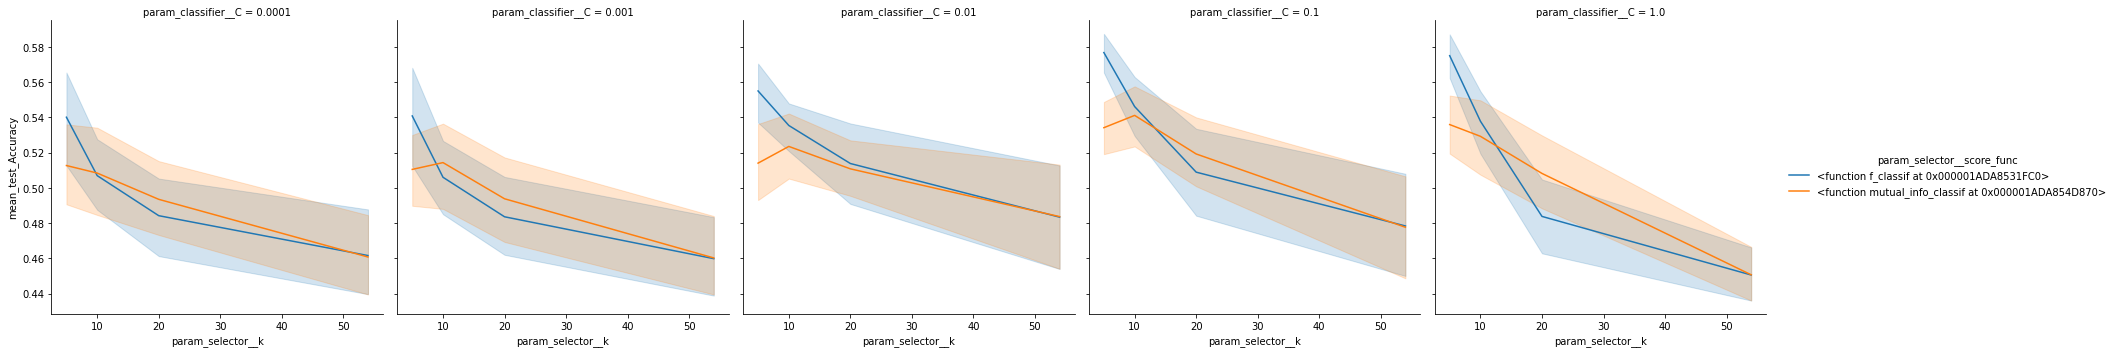

In [35]:
#---------------------------------------------------  
# LINE PLOTS FOR GRIDSEARCH
#-----------------------------------------------------

result_df = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')   
sns.relplot(data=result_df,
kind='line',
x='param_selector__k',
y='mean_test_Accuracy',
hue='param_selector__score_func',
col='param_classifier__C')
plt.show()

In [34]:
grid.best_score_

0.6

In [28]:
functions.grid_to_predictions(grid,'Logistic_Regression_20kolejek',y_test_adh,X_test)

# Gridsearch (training set 29 gameweeks)

In [6]:
df_preprocessed=pd.read_csv('df_after_preprocessing.csv',index_col=0)

final_variables=['BHWinstreak', 'BHLosestreak', 'BAWinstreak', 'BALosestreak', 'cHS',
       'cHF', 'cHY', 'cHR', 'r3FTHG', 'r3HC', 'r3HY', 'r3HR', 'r4HR', 'r5HR',
       'WinsOverH', 'LossesOverH', 'WinstreakH', 'LosestreakH', 'cAF', 'cAR',
       'r3AC', 'r3AF', 'r3AY', 'r3AR', 'r4AR', 'r5FTAG', 'r5AR', 'ewm03_xGA',
       'LoserateA', 'WinsOverA', 'LossesOverA', 'WinstreakA', 'LosestreakA',
       'RestH', 'RestYesNoH', 'FormationCatH', 'FormationChangeH', 'RestA',
       'RestYesNoA', 'FormationCatA', 'FormationChangeA', 'Markov_ratingH',
       'OD_ratingH', 'OD_ratingA', 'SpreadH', 'SpreadA', 'SpreadD', 'HomeAdv',
       'HomeAdv2', 'HomeAdv3', 'HAvgAge', 'HForeigner', 'AAvgAge',
       'AForeigner']
target=['FTR']

df=df_preprocessed[final_variables+target]

X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=1,window=29,forecast=8)

y_test_adh=y_test.copy()
y_train = LabelEncoder().fit_transform(y_train.values.ravel())
y_test = LabelEncoder().fit_transform(y_test.values.ravel())
print(Counter(y_train))
print(Counter(y_test))

Counter({2: 119, 0: 100, 1: 71})
Counter({2: 37, 0: 26, 1: 17})


In [9]:
lr = LogisticRegression()

parameters = {
 'selector__score_func': [f_classif, mutual_info_classif],
 'selector__k': [5,10,20,54],
 'classifier__C':[0.0001, 0.001, 0.01, 0.1, 1.0],
 'classifier__class_weight':['balanced',None],
 'classifier__solver':['newton-cg','sag','saga','lbfgs'],
 'classifier__max_iter':[100],
 'classifier__penalty':['l2',None],
 'classifier__multi_class':['multinomial']
}

run_classifier(clf=lr, param_grid=parameters, title='Logistic_Regression_29kolejek',X_train=X_train,y_train=y_train)

The best parameters are {'classifier__C': 1.0, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__multi_class': 'multinomial', 'classifier__penalty': None, 'classifier__solver': 'saga', 'selector__k': 5, 'selector__score_func': <function mutual_info_classif at 0x000001ADA854D870>}


In [12]:
grid=joblib.load('grid_Logistic_Regression_29kolejek.pkl')
grid.best_score_

0.5827586206896551

In [13]:
functions.grid_to_predictions(grid,'Logistic_Regression_29kolejek',y_test_adh,X_test)

# New grid every gameweek

In [54]:
for i in range(0,8):

    X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=10,window=20+i,forecast=1)

    y_test['FTR'].replace('H',0,regex=True,inplace=True)
    y_test['FTR'].replace('D',1,regex=True,inplace=True)
    y_test['FTR'].replace('A',2,regex=True,inplace=True)
    y_test=y_test['FTR'].values
    y_train['FTR'].replace('H',0,regex=True,inplace=True)
    y_train['FTR'].replace('D',1,regex=True,inplace=True)
    y_train['FTR'].replace('A',2,regex=True,inplace=True)
    y_train=y_train['FTR'].values

    lr = LogisticRegression()

    parameters = {
    'selector__score_func': [f_classif],
    'selector__k': [5,10,20,56],
    'classifier__C':[0.0001, 0.001, 0.01, 0.1, 1.0],
    'classifier__class_weight':['balanced',None],
    'classifier__solver':['newton-cg','saga','lbfgs'],
    'classifier__max_iter':[100],
    'classifier__penalty':['l2',None],
    'classifier__multi_class':['multinomial']
    }

    pipe = Pipeline([
    ('selector', SelectKBest()),
    ('classifier', lr)
    ])

    # -----------------------------------------------

    scoring = {"Accuracy": 'accuracy',"Log_loss":'neg_log_loss',"Precision":make_scorer(precision_score, average = 'macro'),'Recall': make_scorer(recall_score, average = 'macro'),
                'Matthews_corrcoef': make_scorer(matthews_corrcoef),'F1_score':'f1_macro',"AUC":roc_auc_ovr_scorer, 'RPS': rps_scorer}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipe, parameters, cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1).fit(X_train, y_train)

    print("CV Accuracy"+str(grid.best_score_))
    print("Test Accuracy"+str(grid.score(X_test,y_test)))

CV Accuracy0.6
Test Accuracy0.5
CV Accuracy0.5984126984126984
Test Accuracy0.6
CV Accuracy0.5954545454545456
Test Accuracy0.6
CV Accuracy0.5971014492753624
Test Accuracy0.4
CV Accuracy0.5875
Test Accuracy0.6
CV Accuracy0.5866666666666666
Test Accuracy0.8
CV Accuracy0.5974358974358973
Test Accuracy0.3
CV Accuracy0.5876543209876544
Test Accuracy0.7
